In [1]:
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV

from tqdm import trange
from scipy.spatial.distance import cdist
from scipy.stats import randint
import clustering

In [2]:
from IPython.core.interactiveshell import InteractiveShell
from importlib import reload
reload(clustering)
from clustering import *

InteractiveShell.ast_node_interactivity = 'all'
sns.set()
sns.set(rc={'figure.figsize':(12,8)})

## Loading Data

In [3]:
df = pd.read_csv('Diskovery_Cell1_ThunderSTORM.csv')
df.head()

,id,frame,x [nm],y [nm],sigma [nm],intensity [photon],offset [photon],bkgstd [photon],uncertainty [nm]
0,1.0,1.0,2474.998618,6736.088180,195.815722,1841.965445,80.087915,10.501425,9.781846
1,2.0,1.0,4356.136836,14133.322371,145.009192,5599.702004,82.962749,24.851702,4.184589
2,3.0,1.0,4542.775300,9091.265025,121.313419,221.442108,39.507939,4.162599,15.045367
3,4.0,1.0,5977.444344,7594.973438,137.276419,155.518749,39.499220,4.681645,24.730111
4,5.0,1.0,6079.459555,11231.168432,137.261612,2693.631410,59.415820,11.278048,4.647010


## Displaying Raw Data

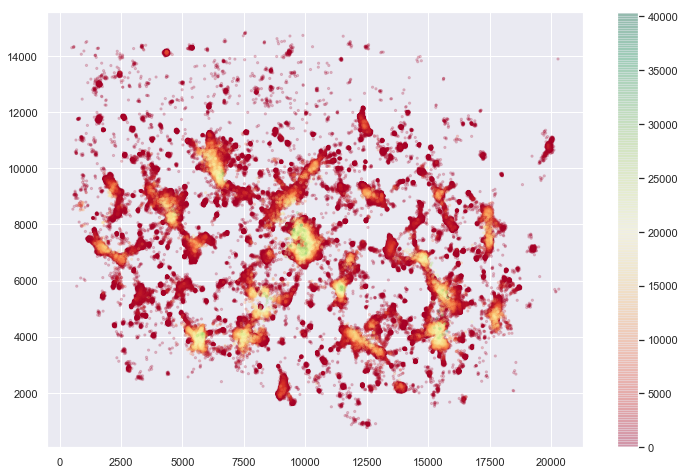

In [6]:
df = df.sort_values(by=['intensity [photon]'])
skip = 1

img = plt.scatter(df[::skip]['x [nm]'],
                  df[::skip]['y [nm]'],
                  c=df[::skip]['intensity [photon]'],
                  s=5, cmap='RdYlGn',alpha=0.2)
_ = plt.colorbar(img)

## Applying DBSCAN

In [7]:
XY = np.column_stack((df['x [nm]'],df['y [nm]']))[::10]

0.6926833828531187

Estimated number of clusters: 96
Estimated number of noise points: 3722
Total number of points: 89939


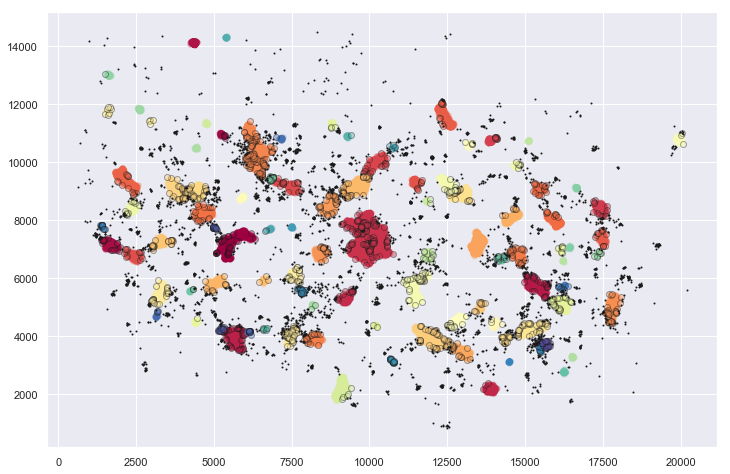

In [19]:
db = DBSCAN(eps=111, min_samples=24, n_jobs=6)
custom_silhouette(db,XY)
dbscan_verbose(db, XY, plot=True)

## Hyper Parameter Search

In [14]:
dbscan = DBSCAN(n_jobs=6)

param_dist = {"eps": randint(108, 127),
              "min_samples": randint(13, 20)}

results_DBSCAN = param_search(dbscan,param_dist,n=100,X=XY)

RandomizedSearchCV took 2035.52 seconds for 100 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.770 (std: 0.028)
Parameters: {'eps': 119, 'min_samples': 15}

Model with rank: 2
Mean validation score: 0.769 (std: 0.029)
Parameters: {'eps': 111, 'min_samples': 14}

Model with rank: 3
Mean validation score: 0.769 (std: 0.030)
Parameters: {'eps': 112, 'min_samples': 14}

